In [2]:
from resnet34Unet import *
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 5
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT = 400
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 200
AUGMENT_BRIGHTNESS = False

## Preprocess data


In [4]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries
try:
    from skimage.util.montage import montage2d
except ImportError as e:
    print('scikit-image is too new, ',e)
    from skimage.util import montage as montage
import gc; gc.enable() # memory is tight
from skimage.morphology import label

scikit-image is too new,  No module named 'skimage.util.montage'


In [5]:
montage_rgb = lambda x: np.stack([montage(x[:, :, :, i]) for i in range(x.shape[3])], -1)
ship_dir = '../data'
train_image_dir = os.path.join(ship_dir, 'train_v2')
test_image_dir = os.path.join(ship_dir, 'test_v2')

In [6]:
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]
def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)

In [7]:
masks = pd.read_csv(os.path.join('../data/', 'train_ship_segmentations_v2.csv'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
masks.head()

231723 masks found
192556


,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


## Make sure encode/decode works

Check Decoding->Encoding RLE_0: 1 -> RLE_1: 1


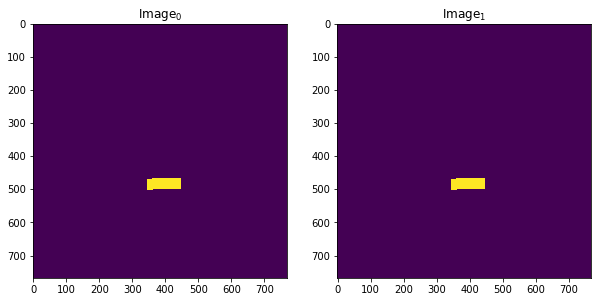

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
rle_0 = masks.query('ImageId=="000155de5.jpg"')['EncodedPixels']
img_0 = masks_as_image(rle_0)

ax1.imshow(img_0[:, :, 0])
ax1.set_title('Image$_0$')

rle_1 = multi_rle_encode(img_0)
img_1 = masks_as_image(rle_1)

ax2.imshow(img_1[:, :, 0])
ax2.set_title('Image$_1$')
print('Check Decoding->Encoding', 'RLE_0:', len(rle_0), '->', 'RLE_1:', len(rle_1))

## Split into training and validation groups

In [115]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)

unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()


,ImageId,ships,has_ship,has_ship_vec,file_size_kb
153047,cb91ff8aa.jpg,1,1.0,[1.0],79.090820
85267,714a7b6b1.jpg,0,0.0,[0.0],125.884766
50872,43c1d9404.jpg,0,0.0,[0.0],117.216797
27794,24fa6865c.jpg,1,1.0,[1.0],122.701172
189089,fb7915bdf.jpg,0,0.0,[0.0],183.829102


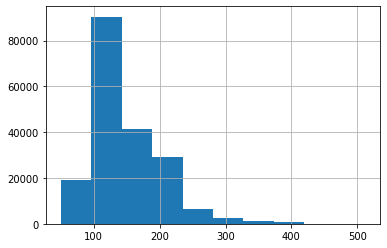

In [116]:
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)

unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

# some files are too small/corrupt
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(lambda c_img_id: 
                                                               os.stat(os.path.join(train_image_dir, c_img_id)).st_size/1024)

unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>50] # keep only 50kb files

unique_img_ids['file_size_kb'].hist()

masks.drop(['ships'], axis=1, inplace=True)

unique_img_ids.sample(5)

In [117]:
from sklearn.model_selection import train_test_split
train_ids, valid_ids = train_test_split(unique_img_ids, 
                 test_size = 0.3, 
                 stratify = unique_img_ids['ships'])

train_df = pd.merge(masks, train_ids)
valid_df = pd.merge(masks, valid_ids)

print(train_df.shape, 'training masks')
print(valid_df.shape, 'validation masks')

(161048, 6) training masks
(69034, 6) validation masks


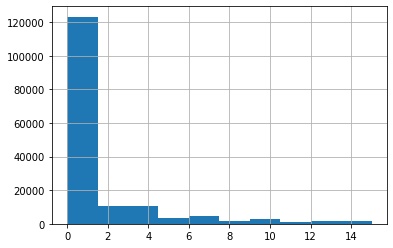

In [118]:
train_df['ships'].hist()

In [119]:
train_df['grouped_ship_count'] = train_df['ships'].map(lambda x: (x+1)//2).clip(0, 7)

11000


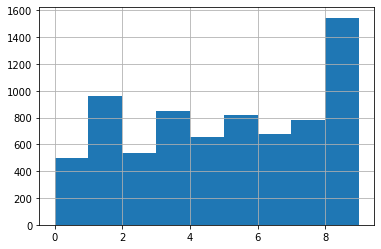

In [120]:
def sample_ships(in_df, base_rep_val=1500):
    if in_df['ships'].values[0]==0:
        return in_df.sample(base_rep_val//3) # even more strongly undersample no ships
    else:
        return in_df.sample(base_rep_val, replace=(in_df.shape[0]<base_rep_val))
    
balanced_train_df = train_df.groupby('grouped_ship_count').apply(sample_ships)
balanced_train_df['ships'].hist(bins=np.arange(10))
print(balanced_train_df.shape[0])

## Decode all the RLEs into Images

In [144]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_rgb = []
    out_mask = []
    while True:
        np.random.shuffle(all_batches)
        for c_img_id, c_masks in all_batches:
            rgb_path = os.path.join(train_image_dir, c_img_id)
            c_img = imread(rgb_path)

            c_mask = masks_as_image(c_masks['EncodedPixels'].values)
            if IMG_SCALING is not None:
                c_img = c_img[::IMG_SCALING[0], ::IMG_SCALING[1]]
                c_mask = c_mask[::IMG_SCALING[0], ::IMG_SCALING[1]]
            out_rgb += [c_img]
            out_mask += [c_mask]
            if len(out_rgb)>=batch_size:
                yield np.stack(out_rgb, 0)/255.0, np.stack(out_mask, 0)
                out_rgb, out_mask=[], []

In [145]:
train_gen = make_image_gen(balanced_train_df)
train_x, train_y = next(train_gen)
print('x', train_x.shape, train_x.min(), train_x.max())
print('y', train_y.shape, train_y.min(), train_y.max())

x (4, 768, 768, 3) 0.0 1.0
y (4, 768, 768, 1) 0 1


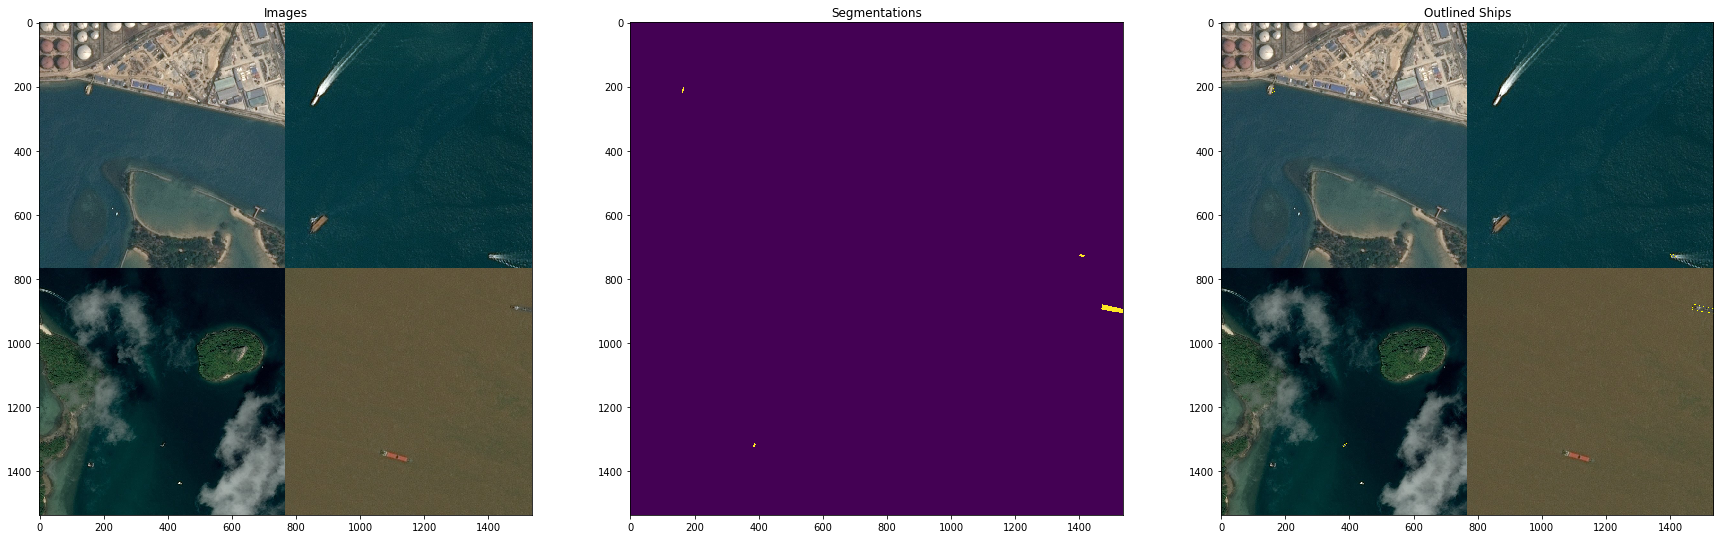

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 10))
batch_rgb = montage_rgb(train_x)
batch_seg = montage(train_y[:, :, :, 0])
ax1.imshow(batch_rgb)
ax1.set_title('Images')
ax2.imshow(batch_seg)
ax2.set_title('Segmentations')
ax3.imshow(mark_boundaries(batch_rgb, 
                           batch_seg.astype(int)))
ax3.set_title('Outlined Ships')
fig.savefig('./overview.png')

In [16]:
valid_x, valid_y = next(make_image_gen(valid_df, VALID_IMG_COUNT))
print(valid_x.shape, valid_y.shape)

(400, 768, 768, 3) (400, 768, 768, 1)


In [17]:
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [18]:
dg_args = dict(featurewise_center = False, 
                  samplewise_center = False,
                  rotation_range = 15, 
                  width_shift_range = 0.1, 
                  height_shift_range = 0.1, 
                  shear_range = 0.01,
                  zoom_range = [0.9, 1.25],  
                  horizontal_flip = True, 
                  vertical_flip = True,
                  fill_mode = 'reflect',
                   data_format = 'channels_last')
# brightness can be problematic since it seems to change the labels differently from the images 
if AUGMENT_BRIGHTNESS:
    dg_args[' brightness_range'] = [0.5, 1.5]
image_gen = ImageDataGenerator(**dg_args)

if AUGMENT_BRIGHTNESS:
    dg_args.pop('brightness_range')
label_gen = ImageDataGenerator(**dg_args)

def create_aug_gen(in_gen, seed = None):
    np.random.seed(seed if seed is not None else np.random.choice(range(9999)))
    for in_x, in_y in in_gen:
        seed = np.random.choice(range(9999))
        # keep the seeds syncronized otherwise the augmentation to the images is different from the masks
        g_x = image_gen.flow(255*in_x, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)
        g_y = label_gen.flow(in_y, 
                             batch_size = in_x.shape[0], 
                             seed = seed, 
                             shuffle=True)

        yield next(g_x)/255.0, next(g_y)

x (4, 768, 768, 3) float32 0.0 1.0
y (4, 768, 768, 1) float32 0.0 1.0


Text(0.5, 1.0, 'ships')

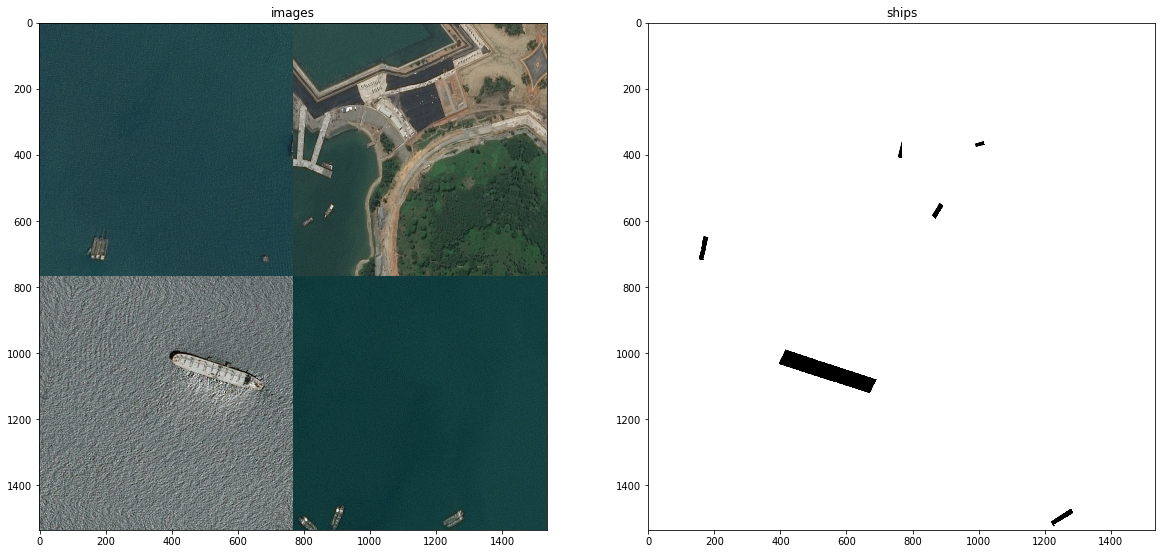

In [19]:
cur_gen = create_aug_gen(train_gen)
t_x, t_y = next(cur_gen)
print('x', t_x.shape, t_x.dtype, t_x.min(), t_x.max())
print('y', t_y.shape, t_y.dtype, t_y.min(), t_y.max())
# only keep first 9 samples to examine in detail
t_x = t_x[:9]
t_y = t_y[:9]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage_rgb(t_x), cmap='gray')
ax1.set_title('images')
ax2.imshow(montage(t_y[:, :, :, 0]), cmap='gray_r')
ax2.set_title('ships')

In [20]:
gc.collect()

27

## Resnet34 with Unet

1. Using pre-trained resnet34
2. Freeze the resnet34's parameters


In [28]:
import torch.optim as optim
model = Resnet34Unet(3, 3)

child_counter = 0
for child in model.children():
    child_counter +=1
    for param in child.parameters():
        param.requires_grad = False
    if child_counter == 6:
        break
optim = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optim, 3, 1e-6, last_epoch=-1)

## Dice Loss

In [ ]:
import torch.nn as nn

class DiceLoss(nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x, y):
        nums = y.size(0)
        smooth = 1
        x_flat = x.view(nums, -1)
        y_flat = y.view(nums, -1)
        
        intersection = x_flat * y_flat
        
        loss = 2 * (intersection.sum(1) + smooth) / (x_flat.sum(1) + y_flat.sum(1) + smooth)
        loss = loss.sum() / nums
        
        return loss

In [ ]:
loss = DiceLoss()
min_loss = np.inf

model.train()

for epoch in range(epochs):
    

